# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [34]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


from imblearn.over_sampling import SMOTE
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [35]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [36]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [37]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [38]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [39]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [40]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [41]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [42]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [49]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [50]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 3796, 0.0: 3796})
Counter({1.0: 1898, 0.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [47]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [52]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.5023 - acc: 0.4982 - val_loss: 0.5008 - val_acc: 0.4997
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.5003 - acc: 0.4995 - val_loss: 0.5003 - val_acc: 0.5000
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.4999 - acc: 0.4997 - val_loss: 0.5005 - val_acc: 0.5000
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.4084 - acc: 0.5701 - val_loss: 0.1592 - val_acc: 0.8232
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1124 - acc: 0.8788 - val_loss: 0.1171 - val_acc: 0.8875
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0937 - acc: 0.8984 - val_loss: 0.1032 - val_acc: 0.8996
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0893 - acc: 0.9015 - val_loss: 0.0963 - val_acc: 0.8981
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9075 - val_loss: 0.0749 - val_acc: 0.9070
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9075 - val_loss: 0.0746 - val_acc: 0.9078
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9081 - val_loss: 0.0758 - val_acc: 0.9062
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9056 - val_loss: 0.0757 - val_acc: 0.9049
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0705 - acc: 0.9079 - val_loss: 0.0760 - val_acc: 0.9052
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0705 - acc: 0.9079 - val_loss: 0.0743 - val_acc: 0.9086
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0705 - acc: 0.9070 - val_loss: 0.0770 - val_acc: 0.9041
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0704 - acc: 0.9069 - val_loss: 0.0754 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9074 - val_loss: 0.0746 - val_acc: 0.9065
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9074 - val_loss: 0.0746 - val_acc: 0.9065
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9073 - val_loss: 0.0762 - val_acc: 0.9052
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9077 - val_loss: 0.0758 - val_acc: 0.9062
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9061 - val_loss: 0.0780 - val_acc: 0.9036
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0701 - acc: 0.9077 - val_loss: 0.0756 - val_acc: 0.9054
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9071 - val_loss: 0.0763 - val_acc: 0.9057
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9075 - val_loss: 0.0753 -

7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9077 - val_loss: 0.0752 - val_acc: 0.9060
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9085 - val_loss: 0.0744 - val_acc: 0.9060
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9079 - val_loss: 0.0772 - val_acc: 0.9038
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9081 - val_loss: 0.0755 - val_acc: 0.9054
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9079 - val_loss: 0.0752 - val_acc: 0.9057
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9074 - val_loss: 0.0750 - val_acc: 0.9057
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9090 - val_loss: 0.0748 - val_acc: 0.9057
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9075 - val_loss: 0.0755 -

7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9075 - val_loss: 0.0753 - val_acc: 0.9054
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9079 - val_loss: 0.0773 - val_acc: 0.9041
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9082 - val_loss: 0.0771 - val_acc: 0.9038
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9075 - val_loss: 0.0752 - val_acc: 0.9067
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9075 - val_loss: 0.0740 - val_acc: 0.9062
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9081 - val_loss: 0.0755 - val_acc: 0.9054
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9077 - val_loss: 0.0740 - val_acc: 0.9065
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9078 - val_loss: 0.0754 -

7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9079 - val_loss: 0.0745 - val_acc: 0.9062
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9081 - val_loss: 0.0750 - val_acc: 0.9052
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9086 - val_loss: 0.0755 - val_acc: 0.9054
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9083 - val_loss: 0.0744 - val_acc: 0.9065
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9066 - val_loss: 0.0743 - val_acc: 0.9067
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9077 - val_loss: 0.0748 - val_acc: 0.9057
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9073 - val_loss: 0.0766 - val_acc: 0.9046
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9083 - val_loss: 0.0735 -

7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9078 - val_loss: 0.0752 - val_acc: 0.9065
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9073 - val_loss: 0.0748 - val_acc: 0.9052
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9082 - val_loss: 0.0752 - val_acc: 0.9067
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9077 - val_loss: 0.0742 - val_acc: 0.9078
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9073 - val_loss: 0.0751 - val_acc: 0.9062
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9077 - val_loss: 0.0752 - val_acc: 0.9060
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9069 - val_loss: 0.0757 - val_acc: 0.9060
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9077 - val_loss: 0.0756 -

7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9078 - val_loss: 0.0749 - val_acc: 0.9057
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9078 - val_loss: 0.0761 - val_acc: 0.9057
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9079 - val_loss: 0.0760 - val_acc: 0.9065
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9082 - val_loss: 0.0762 - val_acc: 0.9057
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9074 - val_loss: 0.0756 - val_acc: 0.9065
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9075 - val_loss: 0.0741 - val_acc: 0.9070
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9079 - val_loss: 0.0757 - val_acc: 0.9060
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9081 - val_loss: 0.0764 -

7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9081 - val_loss: 0.0754 - val_acc: 0.9062
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9073 - val_loss: 0.0744 - val_acc: 0.9060
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9077 - val_loss: 0.0750 - val_acc: 0.9060
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9079 - val_loss: 0.0753 - val_acc: 0.9046
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9083 - val_loss: 0.0761 - val_acc: 0.9046
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9083 - val_loss: 0.0751 - val_acc: 0.9049
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9069 - val_loss: 0.0743 - val_acc: 0.9062
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9085 - val_loss: 0.0747 -

7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9067 - val_loss: 0.0751 - val_acc: 0.9046
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9071 - val_loss: 0.0746 - val_acc: 0.9049
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9071 - val_loss: 0.0758 - val_acc: 0.9049
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9070 - val_loss: 0.0757 - val_acc: 0.9057
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9078 - val_loss: 0.0742 - val_acc: 0.9060
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9070 - val_loss: 0.0763 - val_acc: 0.9038
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9081 - val_loss: 0.0752 - val_acc: 0.9049
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9077 - val_loss: 0.0744 -

7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9083 - val_loss: 0.0773 - val_acc: 0.9038
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9081 - val_loss: 0.0762 - val_acc: 0.9052
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9083 - val_loss: 0.0746 - val_acc: 0.9062
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.0752 - val_acc: 0.9052
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9077 - val_loss: 0.0749 - val_acc: 0.9057
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9091 - val_loss: 0.0754 - val_acc: 0.9054
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9082 - val_loss: 0.0768 - val_acc: 0.9052
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9085 - val_loss: 0.0750 -

7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9099 - val_loss: 0.0749 - val_acc: 0.9067
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9089 - val_loss: 0.0748 - val_acc: 0.9046
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9077 - val_loss: 0.0768 - val_acc: 0.9057
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9083 - val_loss: 0.0745 - val_acc: 0.9057
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9091 - val_loss: 0.0751 - val_acc: 0.9060
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9086 - val_loss: 0.0751 - val_acc: 0.9067
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9085 - val_loss: 0.0773 - val_acc: 0.9052
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9075 - val_loss: 0.0756 -

7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9078 - val_loss: 0.0746 - val_acc: 0.9057
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9089 - val_loss: 0.0758 - val_acc: 0.9065
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9085 - val_loss: 0.0749 - val_acc: 0.9073
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9095 - val_loss: 0.0778 - val_acc: 0.9049
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9079 - val_loss: 0.0757 - val_acc: 0.9070
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9085 - val_loss: 0.0748 - val_acc: 0.9067
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9085 - val_loss: 0.0750 - val_acc: 0.9065
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.0756 -

7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9078 - val_loss: 0.0751 - val_acc: 0.9067
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9081 - val_loss: 0.0778 - val_acc: 0.9057
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9085 - val_loss: 0.0753 - val_acc: 0.9073
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0743 - val_acc: 0.9062
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9085 - val_loss: 0.0757 - val_acc: 0.9073
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0757 - val_acc: 0.9070
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9090 - val_loss: 0.0762 - val_acc: 0.9067
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9090 - val_loss: 0.0767 -

7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9086 - val_loss: 0.0760 - val_acc: 0.9054
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9095 - val_loss: 0.0772 - val_acc: 0.9049
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9079 - val_loss: 0.0759 - val_acc: 0.9052
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9089 - val_loss: 0.0760 - val_acc: 0.9052
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.9038
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9092 - val_loss: 0.0761 - val_acc: 0.9041
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9079 - val_loss: 0.0770 - val_acc: 0.9060
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9090 - val_loss: 0.0762 -

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9092 - val_loss: 0.0788 - val_acc: 0.9023
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9081 - val_loss: 0.0792 - val_acc: 0.9020
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9095 - val_loss: 0.0770 - val_acc: 0.9028
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9095 - val_loss: 0.0777 - val_acc: 0.9020
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9089 - val_loss: 0.0786 - val_acc: 0.9028
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9091 - val_loss: 0.0766 - val_acc: 0.9031
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9094 - val_loss: 0.0768 - val_acc: 0.9007
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9098 - val_loss: 0.0797 -

7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9082 - val_loss: 0.0783 - val_acc: 0.9020
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9094 - val_loss: 0.0773 - val_acc: 0.8994
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9081 - val_loss: 0.0776 - val_acc: 0.9020
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0771 - val_acc: 0.8994
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9089 - val_loss: 0.0764 - val_acc: 0.9007
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9094 - val_loss: 0.0781 - val_acc: 0.9002
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0787 - val_acc: 0.9012
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9091 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9095 - val_loss: 0.0770 - val_acc: 0.9004
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9092 - val_loss: 0.0757 - val_acc: 0.9002
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9083 - val_loss: 0.0761 - val_acc: 0.9004
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9085 - val_loss: 0.0777 - val_acc: 0.8999
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9095 - val_loss: 0.0771 - val_acc: 0.8996
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9081 - val_loss: 0.0775 - val_acc: 0.8988
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9090 - val_loss: 0.0793 - val_acc: 0.9007
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9096 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9094 - val_loss: 0.0779 - val_acc: 0.8999
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9081 - val_loss: 0.0772 - val_acc: 0.8994
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9091 - val_loss: 0.0787 - val_acc: 0.8999
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9089 - val_loss: 0.0781 - val_acc: 0.9002
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0778 - val_acc: 0.8978
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9090 - val_loss: 0.0784 - val_acc: 0.9004
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9091 - val_loss: 0.0773 - val_acc: 0.9002
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9091 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9085 - val_loss: 0.0766 - val_acc: 0.8983
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9092 - val_loss: 0.0763 - val_acc: 0.9002
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9086 - val_loss: 0.0781 - val_acc: 0.8988
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9094 - val_loss: 0.0768 - val_acc: 0.8986
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9092 - val_loss: 0.0778 - val_acc: 0.8986
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0784 - val_acc: 0.8983
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0772 - val_acc: 0.8986
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9081 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9091 - val_loss: 0.0779 - val_acc: 0.8988
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9083 - val_loss: 0.0785 - val_acc: 0.8983
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9091 - val_loss: 0.0777 - val_acc: 0.8999
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9082 - val_loss: 0.0769 - val_acc: 0.8988
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9091 - val_loss: 0.0778 - val_acc: 0.8978
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9085 - val_loss: 0.0775 - val_acc: 0.8988
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9086 - val_loss: 0.0768 - val_acc: 0.8996
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9085 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9089 - val_loss: 0.0774 - val_acc: 0.8988
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9081 - val_loss: 0.0802 - val_acc: 0.8986
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9094 - val_loss: 0.0773 - val_acc: 0.8999
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9086 - val_loss: 0.0775 - val_acc: 0.8983
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9087 - val_loss: 0.0778 - val_acc: 0.8983
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9092 - val_loss: 0.0771 - val_acc: 0.8981
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9086 - val_loss: 0.0776 - val_acc: 0.8978
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9089 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9082 - val_loss: 0.0778 - val_acc: 0.8981
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9094 - val_loss: 0.0790 - val_acc: 0.8991
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9086 - val_loss: 0.0798 - val_acc: 0.8991
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9085 - val_loss: 0.0767 - val_acc: 0.8986
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9085 - val_loss: 0.0782 - val_acc: 0.8986
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9085 - val_loss: 0.0767 - val_acc: 0.9002
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9100 - val_loss: 0.0772 - val_acc: 0.8988
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9094 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0784 - val_acc: 0.9002
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9086 - val_loss: 0.0780 - val_acc: 0.8983
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9089 - val_loss: 0.0798 - val_acc: 0.8986
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9090 - val_loss: 0.0773 - val_acc: 0.8991
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0784 - val_acc: 0.8983
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9086 - val_loss: 0.0778 - val_acc: 0.8991
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0779 - val_acc: 0.8986
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9082 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9085 - val_loss: 0.0782 - val_acc: 0.8999
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9091 - val_loss: 0.0785 - val_acc: 0.8981
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9086 - val_loss: 0.0777 - val_acc: 0.8983
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9081 - val_loss: 0.0766 - val_acc: 0.8983
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9096 - val_loss: 0.0777 - val_acc: 0.8983
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0768 - val_acc: 0.8994
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9095 - val_loss: 0.0784 - val_acc: 0.8978
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9085 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9092 - val_loss: 0.0779 - val_acc: 0.8991
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9085 - val_loss: 0.0763 - val_acc: 0.8999
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0769 - val_acc: 0.8986
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9094 - val_loss: 0.0770 - val_acc: 0.8988
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9079 - val_loss: 0.0773 - val_acc: 0.8994
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9090 - val_loss: 0.0778 - val_acc: 0.8986
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9095 - val_loss: 0.0772 - val_acc: 0.8994
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9090 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9096 - val_loss: 0.0779 - val_acc: 0.8991
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9083 - val_loss: 0.0780 - val_acc: 0.8986
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9089 - val_loss: 0.0791 - val_acc: 0.8991
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0781 - val_acc: 0.8996
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9092 - val_loss: 0.0781 - val_acc: 0.8988
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9089 - val_loss: 0.0780 - val_acc: 0.8994
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9095 - val_loss: 0.0785 - val_acc: 0.8981
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9096 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9082 - val_loss: 0.0777 - val_acc: 0.8988
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9086 - val_loss: 0.0771 - val_acc: 0.8994
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0775 - val_acc: 0.8983
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9081 - val_loss: 0.0777 - val_acc: 0.8996
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9091 - val_loss: 0.0772 - val_acc: 0.8981
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9087 - val_loss: 0.0772 - val_acc: 0.8981
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9089 - val_loss: 0.0772 - val_acc: 0.8996
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9079 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9091 - val_loss: 0.0774 - val_acc: 0.8988
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9085 - val_loss: 0.0780 - val_acc: 0.8986
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9075 - val_loss: 0.0771 - val_acc: 0.8978
Epoch 1768/2000
7592/7592 [==============================] - ETA: 0s - loss: 0.0691 - acc: 0.906 - 0s - loss: 0.0689 - acc: 0.9081 - val_loss: 0.0781 - val_acc: 0.8991
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9089 - val_loss: 0.0795 - val_acc: 0.8978
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9090 - val_loss: 0.0784 - val_acc: 0.9002
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9079 - val_loss: 0.0776 - val_acc: 0.8983
Epoch 1772/2000
7592/7592 [==============================] - 0s - lo

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0786 - val_acc: 0.8988
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9090 - val_loss: 0.0769 - val_acc: 0.8986
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9092 - val_loss: 0.0770 - val_acc: 0.8983
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9085 - val_loss: 0.0774 - val_acc: 0.8973
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9083 - val_loss: 0.0773 - val_acc: 0.8983
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9098 - val_loss: 0.0777 - val_acc: 0.8973
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9083 - val_loss: 0.0771 - val_acc: 0.8991
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9099 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9082 - val_loss: 0.0770 - val_acc: 0.8986
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9073 - val_loss: 0.0775 - val_acc: 0.8981
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0769 - val_acc: 0.8994
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9091 - val_loss: 0.0778 - val_acc: 0.8994
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9083 - val_loss: 0.0771 - val_acc: 0.8978
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9077 - val_loss: 0.0775 - val_acc: 0.8983
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9090 - val_loss: 0.0770 - val_acc: 0.8986
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9083 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9081 - val_loss: 0.0775 - val_acc: 0.8981
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9082 - val_loss: 0.0778 - val_acc: 0.8978
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9092 - val_loss: 0.0765 - val_acc: 0.8978
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9089 - val_loss: 0.0778 - val_acc: 0.8983
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9091 - val_loss: 0.0787 - val_acc: 0.8986
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0774 - val_acc: 0.9002
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9094 - val_loss: 0.0776 - val_acc: 0.8975
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9095 - val_loss: 0

In [53]:
classifier.evaluate(X_test, y_test)
# print (test_loss)

1664/1962 [========================>.....] - ETA: 0s

[0.068851911739107305, 0.92609582065199247]

<IPython.core.display.Javascript object>


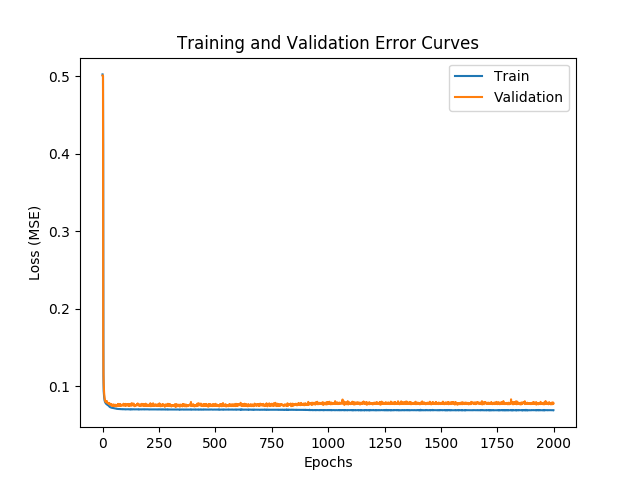

<IPython.core.display.Javascript object>


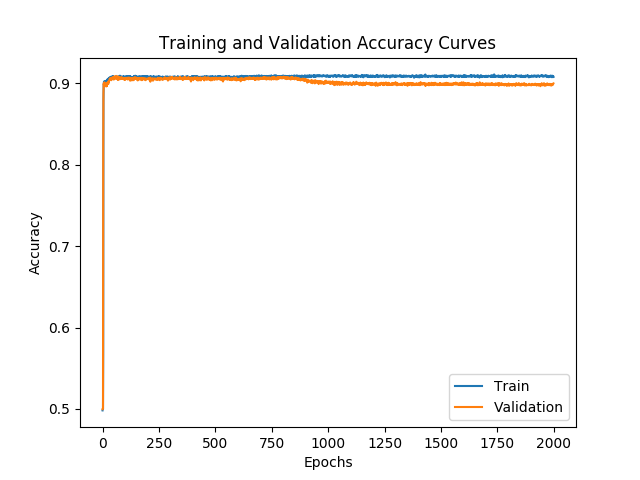

In [54]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 2 (5)

In [55]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.4369 - acc: 0.6628 - val_loss: 0.3030 - val_acc: 0.7081
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1716 - acc: 0.8307 - val_loss: 0.1623 - val_acc: 0.8575
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1135 - acc: 0.8674 - val_loss: 0.1161 - val_acc: 0.8809
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0932 - acc: 0.8905 - val_loss: 0.0987 - val_acc: 0.8872
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0841 - acc: 0.9091 - val_loss: 0.0921 - val_acc: 0.8954
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0792 - acc: 0.9161 - val_loss: 0.0901 - val_acc: 0.8994
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0767 - acc: 0.9193 - val_loss: 0.0885 - val_acc: 0.9028
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9308 - val_loss: 0.0908 - val_acc: 0.8999
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9306 - val_loss: 0.0888 - val_acc: 0.9009
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9311 - val_loss: 0.0892 - val_acc: 0.9017
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9312 - val_loss: 0.0883 - val_acc: 0.9007
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9312 - val_loss: 0.0888 - val_acc: 0.9033
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9312 - val_loss: 0.0897 - val_acc: 0.9023
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9312 - val_loss: 0.0890 - val_acc: 0.9031
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9312 - val_loss: 0.0899 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9334 - val_loss: 0.0801 - val_acc: 0.9099
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9334 - val_loss: 0.0803 - val_acc: 0.9091
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9332 - val_loss: 0.0814 - val_acc: 0.9073
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9330 - val_loss: 0.0802 - val_acc: 0.9099
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9344 - val_loss: 0.0808 - val_acc: 0.9081
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9343 - val_loss: 0.0804 - val_acc: 0.9096
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9344 - val_loss: 0.0815 - val_acc: 0.9075
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9335 - val_loss: 0.0801 -

7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9368 - val_loss: 0.0812 - val_acc: 0.9081
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9361 - val_loss: 0.0825 - val_acc: 0.9078
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9364 - val_loss: 0.0827 - val_acc: 0.9067
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9361 - val_loss: 0.0815 - val_acc: 0.9096
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9357 - val_loss: 0.0821 - val_acc: 0.9070
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9356 - val_loss: 0.0815 - val_acc: 0.9081
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9365 - val_loss: 0.0823 - val_acc: 0.9065
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9366 - val_loss: 0.0822 -

7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9365 - val_loss: 0.0825 - val_acc: 0.9081
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9368 - val_loss: 0.0838 - val_acc: 0.9060
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9364 - val_loss: 0.0847 - val_acc: 0.9012
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9369 - val_loss: 0.0823 - val_acc: 0.9086
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0837 - val_acc: 0.9062
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9364 - val_loss: 0.0837 - val_acc: 0.9044
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9359 - val_loss: 0.0826 - val_acc: 0.9094
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9365 - val_loss: 0.0841 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0834 - val_acc: 0.9057
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0830 - val_acc: 0.9067
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9360 - val_loss: 0.0833 - val_acc: 0.9067
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0838 - val_acc: 0.9046
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9366 - val_loss: 0.0839 - val_acc: 0.9052
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9362 - val_loss: 0.0838 - val_acc: 0.9046
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9356 - val_loss: 0.0834 - val_acc: 0.9049
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9357 - val_loss: 0.0838 -

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9362 - val_loss: 0.0832 - val_acc: 0.9054
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9362 - val_loss: 0.0837 - val_acc: 0.9065
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9356 - val_loss: 0.0832 - val_acc: 0.9078
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9365 - val_loss: 0.0833 - val_acc: 0.9070
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0833 - val_acc: 0.9065
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9372 - val_loss: 0.0829 - val_acc: 0.9075
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9365 - val_loss: 0.0833 - val_acc: 0.9067
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0845 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0842 - val_acc: 0.9031
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9356 - val_loss: 0.0837 - val_acc: 0.9067
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9366 - val_loss: 0.0836 - val_acc: 0.9046
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9362 - val_loss: 0.0840 - val_acc: 0.9046
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0837 - val_acc: 0.9065
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0836 - val_acc: 0.9052
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9365 - val_loss: 0.0832 - val_acc: 0.9065
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0844 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9368 - val_loss: 0.0846 - val_acc: 0.9031
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9364 - val_loss: 0.0835 - val_acc: 0.9075
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9364 - val_loss: 0.0844 - val_acc: 0.9025
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9366 - val_loss: 0.0844 - val_acc: 0.9046
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0846 - val_acc: 0.9049
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0.0849 - val_acc: 0.9036
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0839 - val_acc: 0.9060
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0835 -

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9355 - val_loss: 0.0845 - val_acc: 0.9036
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0835 - val_acc: 0.9054
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9360 - val_loss: 0.0852 - val_acc: 0.9025
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0837 - val_acc: 0.9062
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9357 - val_loss: 0.0845 - val_acc: 0.9041
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9359 - val_loss: 0.0843 - val_acc: 0.9041
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9357 - val_loss: 0.0838 - val_acc: 0.9049
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0835 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0839 - val_acc: 0.9049
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0843 - val_acc: 0.9033
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9368 - val_loss: 0.0846 - val_acc: 0.9033
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0849 - val_acc: 0.9017
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9356 - val_loss: 0.0847 - val_acc: 0.9025
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0833 - val_acc: 0.9057
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9368 - val_loss: 0.0846 - val_acc: 0.9017
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9359 - val_loss: 0.0838 -

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0830 - val_acc: 0.9067
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0.0829 - val_acc: 0.9067
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9359 - val_loss: 0.0833 - val_acc: 0.9067
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0847 - val_acc: 0.9031
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0841 - val_acc: 0.9036
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0854 - val_acc: 0.8988
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0849 - val_acc: 0.9017
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0839 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0.0833 - val_acc: 0.9054
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0837 - val_acc: 0.9046
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0832 - val_acc: 0.9057
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0829 - val_acc: 0.9070
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0829 - val_acc: 0.9078
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9355 - val_loss: 0.0828 - val_acc: 0.9073
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9356 - val_loss: 0.0830 - val_acc: 0.9083
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0833 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9362 - val_loss: 0.0834 - val_acc: 0.9067
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0.0835 - val_acc: 0.9081
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0849 - val_acc: 0.9007
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9357 - val_loss: 0.0841 - val_acc: 0.9038
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0841 - val_acc: 0.9041
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0859 - val_acc: 0.8999
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9353 - val_loss: 0.0836 - val_acc: 0.9057
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0.0843 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9357 - val_loss: 0.0836 - val_acc: 0.9049
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0837 - val_acc: 0.9046
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9357 - val_loss: 0.0839 - val_acc: 0.9041
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9359 - val_loss: 0.0836 - val_acc: 0.9038
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9356 - val_loss: 0.0842 - val_acc: 0.9028
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9362 - val_loss: 0.0835 - val_acc: 0.9041
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0849 - val_acc: 0.8986
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0839 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9362 - val_loss: 0.0844 - val_acc: 0.9031
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0844 - val_acc: 0.8999
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9359 - val_loss: 0.0845 - val_acc: 0.9031
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0848 - val_acc: 0.8996
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9370 - val_loss: 0.0843 - val_acc: 0.9036
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0843 - val_acc: 0.9028
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0841 - val_acc: 0.9028
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0852 -

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0858 - val_acc: 0.8970
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0849 - val_acc: 0.8986
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9359 - val_loss: 0.0846 - val_acc: 0.9023
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0837 - val_acc: 0.9041
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0845 - val_acc: 0.9023
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0843 - val_acc: 0.9025
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0845 - val_acc: 0.9036
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0853 - val_acc: 0.8988
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0850 - val_acc: 0.8986
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9356 - val_loss: 0.0841 - val_acc: 0.9031
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0843 - val_acc: 0.9031
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9370 - val_loss: 0.0849 - val_acc: 0.8994
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0849 - val_acc: 0.9007
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0851 - val_acc: 0.9025
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0842 - val_acc: 0.9028
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0855 - val_acc: 0.8978
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9369 - val_loss: 0.0845 - val_acc: 0.9023
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0849 - val_acc: 0.9009
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0844 - val_acc: 0.9031
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0847 - val_acc: 0.9017
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9370 - val_loss: 0.0846 - val_acc: 0.9036
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0856 - val_acc: 0.8986
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0853 - val_acc: 0.8991
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0848 - val_acc: 0.9025
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0846 - val_acc: 0.9023
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0844 - val_acc: 0.9017
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0840 - val_acc: 0.9036
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0854 - val_acc: 0.8996
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0842 - val_acc: 0.9036
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0848 - val_acc: 0.9031
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9368 - val_loss: 0.0844 - val_acc: 0.9028
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9359 - val_loss: 0.0852 - val_acc: 0.8983
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0858 - val_acc: 0.8994
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0850 - val_acc: 0.9009
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0842 - val_acc: 0.9041
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0847 - val_acc: 0.9023
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0848 - val_acc: 0.9031
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0850 - val_acc: 0.9020
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0845 - val_acc: 0.9036
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0850 - val_acc: 0.9009
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9360 - val_loss: 0.0848 - val_acc: 0.9028
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0854 - val_acc: 0.8983
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9376 - val_loss: 0.0849 - val_acc: 0.9004
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0850 - val_acc: 0.9025
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9360 - val_loss: 0.0847 - val_acc: 0.9041
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9372 - val_loss: 0.0854 - val_acc: 0.8994
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0862 - val_acc: 0.8981
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0850 - val_acc: 0.9012
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0854 - val_acc: 0.8994
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0862 - val_acc: 0.8975
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0849 - val_acc: 0.9012
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0854 - val_acc: 0.8983
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0847 - val_acc: 0.9025
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9360 - val_loss: 0.0851 - val_acc: 0.9009
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0860 - val_acc: 0.8994
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0852 - val_acc: 0.9002
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0848 - val_acc: 0.9033
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0859 - val_acc: 0.8991
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9353 - val_loss: 0.0850 - val_acc: 0.9028
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0847 - val_acc: 0.9036
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9370 - val_loss: 0.0852 - val_acc: 0.9020
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9370 - val_loss: 0.0861 - val_acc: 0.8988
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0853 - val_acc: 0.8994
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9373 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0850 - val_acc: 0.9020
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9372 - val_loss: 0.0853 - val_acc: 0.9028
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0853 - val_acc: 0.9025
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0851 - val_acc: 0.9004
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0854 - val_acc: 0.9009
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9356 - val_loss: 0.0850 - val_acc: 0.8999
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0859 - val_acc: 0.8981
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9370 - val_loss: 0.0866 - val_acc: 0.8988
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0863 - val_acc: 0.8996
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0858 - val_acc: 0.9012
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9373 - val_loss: 0.0859 - val_acc: 0.9009
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0857 - val_acc: 0.9020
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9370 - val_loss: 0.0860 - val_acc: 0.9007
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0869 - val_acc: 0.8983
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9359 - val_loss: 0.0855 - val_acc: 0.9033
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0858 - val_acc: 0.9015
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0.0862 - val_acc: 0.8999
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9359 - val_loss: 0.0853 - val_acc: 0.9028
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0854 - val_acc: 0.9025
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0857 - val_acc: 0.9017
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0857 - val_acc: 0.9028
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0854 - val_acc: 0.9033
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0856 - val_acc: 0.9028
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9372 - val_loss: 0.0862 - val_acc: 0.8999
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9369 - val_loss: 0.0855 - val_acc: 0.9025
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0856 - val_acc: 0.9025
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9364 - val_loss: 0.0859 - val_acc: 0.9023
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9357 - val_loss: 0.0859 - val_acc: 0.9009
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9355 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9357 - val_loss: 0.0860 - val_acc: 0.9007
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0859 - val_acc: 0.9023
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0855 - val_acc: 0.9023
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0857 - val_acc: 0.9025
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0865 - val_acc: 0.8978
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0854 - val_acc: 0.9041
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0.0856 - val_acc: 0.9033
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9364 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0858 - val_acc: 0.9020
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0859 - val_acc: 0.9007
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0856 - val_acc: 0.9036
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9364 - val_loss: 0.0862 - val_acc: 0.9017
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0863 - val_acc: 0.8996
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0858 - val_acc: 0.9015
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0865 - val_acc: 0.8981
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9360 - val_loss: 0.0852 - val_acc: 0.9025
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0853 - val_acc: 0.9025
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9370 - val_loss: 0.0858 - val_acc: 0.9017
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0864 - val_acc: 0.8988
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9361 - val_loss: 0.0857 - val_acc: 0.9033
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9366 - val_loss: 0.0870 - val_acc: 0.8986
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0855 - val_acc: 0.9020
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0

In [56]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.031945800540207389, 0.95616717622914449]


<IPython.core.display.Javascript object>


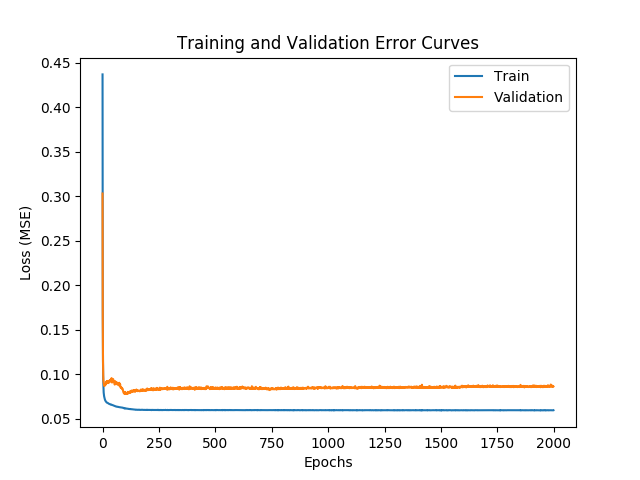

<IPython.core.display.Javascript object>


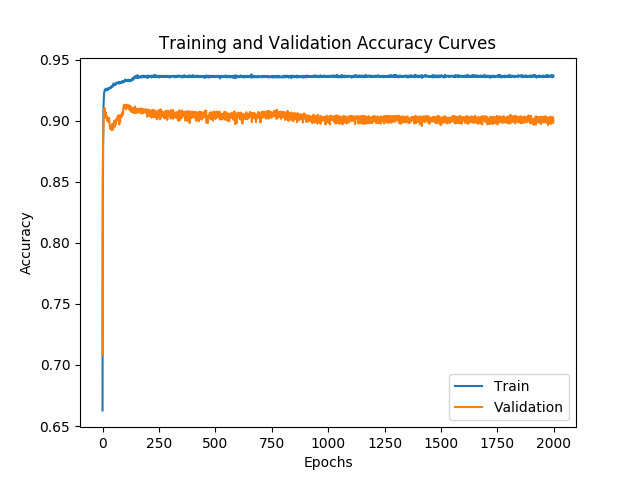

In [57]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 3 (3, 5)

In [59]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2754 - acc: 0.5987 - val_loss: 0.1835 - val_acc: 0.7050
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1183 - acc: 0.8525 - val_loss: 0.1204 - val_acc: 0.8743
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0923 - acc: 0.8938 - val_loss: 0.1064 - val_acc: 0.8841
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0852 - acc: 0.9013 - val_loss: 0.1020 - val_acc: 0.8836
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0818 - acc: 0.9044 - val_loss: 0.0989 - val_acc: 0.8891
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.0946 - val_acc: 0.8957
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0769 - acc: 0.9077 - val_loss: 0.0919 - val_acc: 0.8991
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9269 - val_loss: 0.0649 - val_acc: 0.9223
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9274 - val_loss: 0.0650 - val_acc: 0.9223
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9273 - val_loss: 0.0643 - val_acc: 0.9249
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9269 - val_loss: 0.0656 - val_acc: 0.9236
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9274 - val_loss: 0.0657 - val_acc: 0.9231
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9273 - val_loss: 0.0660 - val_acc: 0.9228
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9287 - val_loss: 0.0654 - val_acc: 0.9247
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9287 - val_loss: 0.0637 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0553 - acc: 0.9306 - val_loss: 0.0659 - val_acc: 0.9162
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9315 - val_loss: 0.0659 - val_acc: 0.9141
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0555 - acc: 0.9311 - val_loss: 0.0647 - val_acc: 0.9202
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9314 - val_loss: 0.0678 - val_acc: 0.9136
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0558 - acc: 0.9303 - val_loss: 0.0652 - val_acc: 0.9170
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9318 - val_loss: 0.0668 - val_acc: 0.9168
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9308 - val_loss: 0.0649 - val_acc: 0.9178
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9318 - val_loss: 0.0654 -

7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9320 - val_loss: 0.0693 - val_acc: 0.9117
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9323 - val_loss: 0.0658 - val_acc: 0.9165
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0549 - acc: 0.9315 - val_loss: 0.0708 - val_acc: 0.9125
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9322 - val_loss: 0.0663 - val_acc: 0.9165
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9327 - val_loss: 0.0666 - val_acc: 0.9154
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9320 - val_loss: 0.0671 - val_acc: 0.9139
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9332 - val_loss: 0.0679 - val_acc: 0.9157
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9322 - val_loss: 0.0647 -

7592/7592 [==============================] - 0s - loss: 0.0549 - acc: 0.9328 - val_loss: 0.0656 - val_acc: 0.9197
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0549 - acc: 0.9327 - val_loss: 0.0674 - val_acc: 0.9162
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0544 - acc: 0.9324 - val_loss: 0.0675 - val_acc: 0.9149
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9324 - val_loss: 0.0657 - val_acc: 0.9204
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9327 - val_loss: 0.0671 - val_acc: 0.9133
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9322 - val_loss: 0.0674 - val_acc: 0.9131
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9314 - val_loss: 0.0658 - val_acc: 0.9181
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0544 - acc: 0.9320 - val_loss: 0.0662 -

7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9331 - val_loss: 0.0694 - val_acc: 0.9067
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9315 - val_loss: 0.0680 - val_acc: 0.9139
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0543 - acc: 0.9331 - val_loss: 0.0659 - val_acc: 0.9160
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9340 - val_loss: 0.0688 - val_acc: 0.9128
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9324 - val_loss: 0.0646 - val_acc: 0.9194
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9348 - val_loss: 0.0682 - val_acc: 0.9136
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0543 - acc: 0.9331 - val_loss: 0.0672 - val_acc: 0.9139
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0544 - acc: 0.9337 - val_loss: 0.0655 -

7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9339 - val_loss: 0.0638 - val_acc: 0.9202
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9339 - val_loss: 0.0659 - val_acc: 0.9162
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0541 - acc: 0.9324 - val_loss: 0.0673 - val_acc: 0.9136
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0543 - acc: 0.9337 - val_loss: 0.0656 - val_acc: 0.9152
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9339 - val_loss: 0.0667 - val_acc: 0.9144
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9340 - val_loss: 0.0657 - val_acc: 0.9146
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9337 - val_loss: 0.0657 - val_acc: 0.9146
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9335 - val_loss: 0.0667 -

7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9349 - val_loss: 0.0657 - val_acc: 0.9165
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9348 - val_loss: 0.0674 - val_acc: 0.9149
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9348 - val_loss: 0.0661 - val_acc: 0.9152
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0537 - acc: 0.9355 - val_loss: 0.0648 - val_acc: 0.9157
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9349 - val_loss: 0.0648 - val_acc: 0.9162
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9339 - val_loss: 0.0661 - val_acc: 0.9139
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9352 - val_loss: 0.0655 - val_acc: 0.9144
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9337 - val_loss: 0.0666 -

7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9362 - val_loss: 0.0632 - val_acc: 0.9194
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9364 - val_loss: 0.0680 - val_acc: 0.9110
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9366 - val_loss: 0.0627 - val_acc: 0.9189
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9364 - val_loss: 0.0640 - val_acc: 0.9154
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9370 - val_loss: 0.0640 - val_acc: 0.9170
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9357 - val_loss: 0.0635 - val_acc: 0.9162
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9359 - val_loss: 0.0629 - val_acc: 0.9191
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9370 - val_loss: 0.0646 -

7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9374 - val_loss: 0.0662 - val_acc: 0.9133
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9384 - val_loss: 0.0684 - val_acc: 0.9102
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9374 - val_loss: 0.0686 - val_acc: 0.9107
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9381 - val_loss: 0.0665 - val_acc: 0.9125
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9384 - val_loss: 0.0636 - val_acc: 0.9160
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9365 - val_loss: 0.0649 - val_acc: 0.9154
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9380 - val_loss: 0.0651 - val_acc: 0.9144
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9378 - val_loss: 0.0674 -

7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9389 - val_loss: 0.0667 - val_acc: 0.9120
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9374 - val_loss: 0.0708 - val_acc: 0.9078
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9393 - val_loss: 0.0672 - val_acc: 0.9117
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9390 - val_loss: 0.0663 - val_acc: 0.9133
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9389 - val_loss: 0.0653 - val_acc: 0.9136
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9393 - val_loss: 0.0669 - val_acc: 0.9117
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9391 - val_loss: 0.0680 - val_acc: 0.9112
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9386 - val_loss: 0.0656 -

7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9389 - val_loss: 0.0681 - val_acc: 0.9115
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9386 - val_loss: 0.0656 - val_acc: 0.9157
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9397 - val_loss: 0.0703 - val_acc: 0.9107
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9384 - val_loss: 0.0667 - val_acc: 0.9117
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9390 - val_loss: 0.0694 - val_acc: 0.9099
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9390 - val_loss: 0.0695 - val_acc: 0.9086
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9391 - val_loss: 0.0683 - val_acc: 0.9110
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9390 - val_loss: 0.0665 -

7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9385 - val_loss: 0.0741 - val_acc: 0.9062
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9384 - val_loss: 0.0723 - val_acc: 0.9089
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9388 - val_loss: 0.0663 - val_acc: 0.9149
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9386 - val_loss: 0.0696 - val_acc: 0.9102
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9386 - val_loss: 0.0677 - val_acc: 0.9125
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9390 - val_loss: 0.0670 - val_acc: 0.9136
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9360 - val_loss: 0.0681 - val_acc: 0.9078
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9382 - val_loss: 0.0696 -

7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9391 - val_loss: 0.0663 - val_acc: 0.9131
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9399 - val_loss: 0.0688 - val_acc: 0.9089
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9389 - val_loss: 0.0703 - val_acc: 0.9086
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9380 - val_loss: 0.0644 - val_acc: 0.9149
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9384 - val_loss: 0.0692 - val_acc: 0.9083
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9384 - val_loss: 0.0698 - val_acc: 0.9073
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9386 - val_loss: 0.0667 - val_acc: 0.9162
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9397 - val_loss: 0.0699 -

7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9402 - val_loss: 0.0709 - val_acc: 0.9075
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9391 - val_loss: 0.0742 - val_acc: 0.9041
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9403 - val_loss: 0.0654 - val_acc: 0.9154
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9398 - val_loss: 0.0714 - val_acc: 0.9089
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9391 - val_loss: 0.0701 - val_acc: 0.9065
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9397 - val_loss: 0.0694 - val_acc: 0.9075
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9386 - val_loss: 0.0693 - val_acc: 0.9102
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9388 - val_loss: 0.0659 -

7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9402 - val_loss: 0.0691 - val_acc: 0.9112
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9415 - val_loss: 0.0667 - val_acc: 0.9149
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9393 - val_loss: 0.0704 - val_acc: 0.9083
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9389 - val_loss: 0.0695 - val_acc: 0.9115
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9405 - val_loss: 0.0671 - val_acc: 0.9120
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9401 - val_loss: 0.0663 - val_acc: 0.9139
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9399 - val_loss: 0.0701 - val_acc: 0.9096
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9415 - val_loss: 0.0670 -

7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9415 - val_loss: 0.0746 - val_acc: 0.9065
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9418 - val_loss: 0.0774 - val_acc: 0.9044
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9416 - val_loss: 0.0759 - val_acc: 0.9025
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9406 - val_loss: 0.0741 - val_acc: 0.9049
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9409 - val_loss: 0.0685 - val_acc: 0.9107
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9413 - val_loss: 0.0738 - val_acc: 0.9073
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9414 - val_loss: 0.0718 - val_acc: 0.9078
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9413 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9419 - val_loss: 0.0681 - val_acc: 0.9117
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9428 - val_loss: 0.0652 - val_acc: 0.9186
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9424 - val_loss: 0.0676 - val_acc: 0.9157
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9422 - val_loss: 0.0766 - val_acc: 0.9033
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9420 - val_loss: 0.0705 - val_acc: 0.9123
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0511 - acc: 0.9423 - val_loss: 0.0683 - val_acc: 0.9133
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9399 - val_loss: 0.0703 - val_acc: 0.9067
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9390 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9419 - val_loss: 0.0680 - val_acc: 0.9149
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9422 - val_loss: 0.0668 - val_acc: 0.9123
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9403 - val_loss: 0.0757 - val_acc: 0.9060
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9416 - val_loss: 0.0757 - val_acc: 0.9057
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9414 - val_loss: 0.0743 - val_acc: 0.9057
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9410 - val_loss: 0.0705 - val_acc: 0.9123
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9422 - val_loss: 0.0766 - val_acc: 0.9054
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9413 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0511 - acc: 0.9410 - val_loss: 0.0716 - val_acc: 0.9115
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9427 - val_loss: 0.0688 - val_acc: 0.9110
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9418 - val_loss: 0.0724 - val_acc: 0.9110
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9403 - val_loss: 0.0733 - val_acc: 0.9067
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9385 - val_loss: 0.0645 - val_acc: 0.9157
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9391 - val_loss: 0.0778 - val_acc: 0.9015
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9410 - val_loss: 0.0713 - val_acc: 0.9120
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0511 - acc: 0.9413 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9416 - val_loss: 0.0691 - val_acc: 0.9136
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9426 - val_loss: 0.0747 - val_acc: 0.9073
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9424 - val_loss: 0.0659 - val_acc: 0.9168
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9426 - val_loss: 0.0781 - val_acc: 0.9046
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9424 - val_loss: 0.0794 - val_acc: 0.9031
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9391 - val_loss: 0.0777 - val_acc: 0.9038
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9418 - val_loss: 0.0711 - val_acc: 0.9112
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9419 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9386 - val_loss: 0.0708 - val_acc: 0.9060
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9386 - val_loss: 0.0751 - val_acc: 0.9060
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9420 - val_loss: 0.0763 - val_acc: 0.9065
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9426 - val_loss: 0.0696 - val_acc: 0.9133
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9420 - val_loss: 0.0717 - val_acc: 0.9094
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9418 - val_loss: 0.0784 - val_acc: 0.9049
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9432 - val_loss: 0.0741 - val_acc: 0.9094
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9397 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9406 - val_loss: 0.0759 - val_acc: 0.9054
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9422 - val_loss: 0.0689 - val_acc: 0.9133
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9415 - val_loss: 0.0719 - val_acc: 0.9115
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9430 - val_loss: 0.0711 - val_acc: 0.9120
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9423 - val_loss: 0.0698 - val_acc: 0.9149
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9415 - val_loss: 0.0751 - val_acc: 0.9083
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9427 - val_loss: 0.0735 - val_acc: 0.9096
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9422 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9416 - val_loss: 0.0759 - val_acc: 0.9062
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9423 - val_loss: 0.0743 - val_acc: 0.9096
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9413 - val_loss: 0.0735 - val_acc: 0.9094
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9409 - val_loss: 0.0794 - val_acc: 0.9025
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9413 - val_loss: 0.0720 - val_acc: 0.9120
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9418 - val_loss: 0.0744 - val_acc: 0.9099
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9410 - val_loss: 0.0721 - val_acc: 0.9099
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9366 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9419 - val_loss: 0.0703 - val_acc: 0.9141
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9424 - val_loss: 0.0701 - val_acc: 0.9139
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9427 - val_loss: 0.0814 - val_acc: 0.9033
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9403 - val_loss: 0.0764 - val_acc: 0.9057
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0511 - acc: 0.9423 - val_loss: 0.0763 - val_acc: 0.9067
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0511 - acc: 0.9420 - val_loss: 0.0760 - val_acc: 0.9060
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9410 - val_loss: 0.0777 - val_acc: 0.9031
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9405 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9413 - val_loss: 0.0737 - val_acc: 0.9123
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9423 - val_loss: 0.0781 - val_acc: 0.9057
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0507 - acc: 0.9424 - val_loss: 0.0744 - val_acc: 0.9078
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9402 - val_loss: 0.0779 - val_acc: 0.9041
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9424 - val_loss: 0.0779 - val_acc: 0.9031
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9391 - val_loss: 0.0748 - val_acc: 0.9075
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9413 - val_loss: 0.0759 - val_acc: 0.9070
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0507 - acc: 0.9405 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9426 - val_loss: 0.0749 - val_acc: 0.9115
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9438 - val_loss: 0.0754 - val_acc: 0.9099
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9418 - val_loss: 0.0722 - val_acc: 0.9133
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9411 - val_loss: 0.0730 - val_acc: 0.9102
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9415 - val_loss: 0.0704 - val_acc: 0.9154
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9424 - val_loss: 0.0761 - val_acc: 0.9081
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9427 - val_loss: 0.0751 - val_acc: 0.9086
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9432 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9415 - val_loss: 0.0738 - val_acc: 0.9112
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9431 - val_loss: 0.0720 - val_acc: 0.9146
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9443 - val_loss: 0.0724 - val_acc: 0.9149
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9431 - val_loss: 0.0748 - val_acc: 0.9115
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9426 - val_loss: 0.0741 - val_acc: 0.9104
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0494 - acc: 0.9434 - val_loss: 0.0739 - val_acc: 0.9125
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9428 - val_loss: 0.0758 - val_acc: 0.9073
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9424 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9422 - val_loss: 0.0781 - val_acc: 0.9017
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9445 - val_loss: 0.0713 - val_acc: 0.9186
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9438 - val_loss: 0.0737 - val_acc: 0.9110
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9431 - val_loss: 0.0793 - val_acc: 0.9046
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9414 - val_loss: 0.0758 - val_acc: 0.9094
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9426 - val_loss: 0.0746 - val_acc: 0.9120
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9431 - val_loss: 0.0698 - val_acc: 0.9191
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9422 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9427 - val_loss: 0.0734 - val_acc: 0.9154
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9426 - val_loss: 0.0725 - val_acc: 0.9136
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9426 - val_loss: 0.0723 - val_acc: 0.9168
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9423 - val_loss: 0.0765 - val_acc: 0.9041
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9390 - val_loss: 0.0706 - val_acc: 0.9181
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9432 - val_loss: 0.0733 - val_acc: 0.9125
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9436 - val_loss: 0.0721 - val_acc: 0.9189
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9440 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0495 - acc: 0.9443 - val_loss: 0.0747 - val_acc: 0.9131
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9430 - val_loss: 0.0737 - val_acc: 0.9117
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0504 - acc: 0.9394 - val_loss: 0.0769 - val_acc: 0.9086
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9427 - val_loss: 0.0736 - val_acc: 0.9120
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9438 - val_loss: 0.0722 - val_acc: 0.9170
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0499 - acc: 0.9418 - val_loss: 0.0734 - val_acc: 0.9102
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9427 - val_loss: 0.0743 - val_acc: 0.9117
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9424 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9426 - val_loss: 0.0701 - val_acc: 0.9199
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9435 - val_loss: 0.0718 - val_acc: 0.9181
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9430 - val_loss: 0.0723 - val_acc: 0.9175
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9434 - val_loss: 0.0702 - val_acc: 0.9189
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9431 - val_loss: 0.0715 - val_acc: 0.9170
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9430 - val_loss: 0.0707 - val_acc: 0.9175
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9439 - val_loss: 0.0706 - val_acc: 0.9186
Epoch 1961/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9435 - val_loss: 0

In [60]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1280/1962 [==================>...........] - ETA: 0s[0.054532340497051905, 0.91641182472946447]


<IPython.core.display.Javascript object>


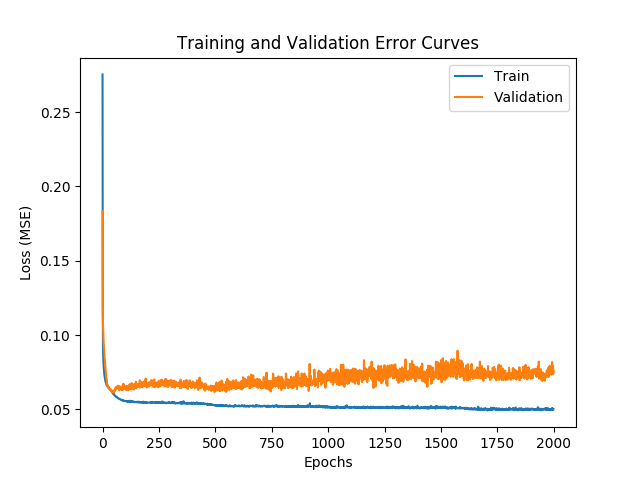

<IPython.core.display.Javascript object>


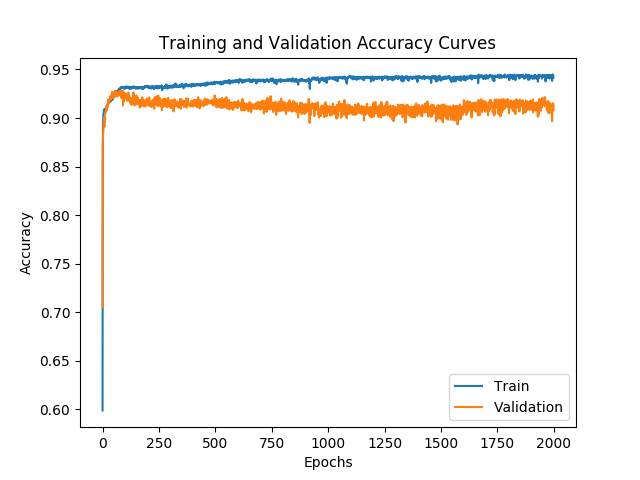

In [61]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 4 (5,3)

In [63]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2242 - acc: 0.7408 - val_loss: 0.1430 - val_acc: 0.8477
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1119 - acc: 0.8749 - val_loss: 0.1182 - val_acc: 0.8746
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0925 - acc: 0.8911 - val_loss: 0.1044 - val_acc: 0.8875
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0856 - acc: 0.8967 - val_loss: 0.0955 - val_acc: 0.8917
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0814 - acc: 0.9031 - val_loss: 0.0924 - val_acc: 0.8917
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0786 - acc: 0.9061 - val_loss: 0.0905 - val_acc: 0.8941
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0768 - acc: 0.9086 - val_loss: 0.0910 - val_acc: 0.8938
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9274 - val_loss: 0.0839 - val_acc: 0.9015
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9274 - val_loss: 0.0846 - val_acc: 0.8988
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.0834 - val_acc: 0.9020
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9277 - val_loss: 0.0835 - val_acc: 0.9033
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9291 - val_loss: 0.0844 - val_acc: 0.8988
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9283 - val_loss: 0.0842 - val_acc: 0.8996
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9285 - val_loss: 0.0838 - val_acc: 0.9020
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9293 - val_loss: 0.0840 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0611 - acc: 0.9340 - val_loss: 0.0868 - val_acc: 0.8970
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9332 - val_loss: 0.0862 - val_acc: 0.8986
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0611 - acc: 0.9341 - val_loss: 0.0874 - val_acc: 0.8959
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9324 - val_loss: 0.0865 - val_acc: 0.8978
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9335 - val_loss: 0.0860 - val_acc: 0.8988
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9332 - val_loss: 0.0871 - val_acc: 0.8954
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0611 - acc: 0.9334 - val_loss: 0.0874 - val_acc: 0.8962
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9334 - val_loss: 0.0879 -

7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9340 - val_loss: 0.0884 - val_acc: 0.8938
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9336 - val_loss: 0.0860 - val_acc: 0.8986
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9337 - val_loss: 0.0876 - val_acc: 0.8959
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9336 - val_loss: 0.0864 - val_acc: 0.8957
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9339 - val_loss: 0.0868 - val_acc: 0.8954
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9345 - val_loss: 0.0874 - val_acc: 0.8957
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9340 - val_loss: 0.0865 - val_acc: 0.8978
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9341 - val_loss: 0.0867 -

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0901 - val_acc: 0.8923
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9364 - val_loss: 0.0905 - val_acc: 0.8941
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9360 - val_loss: 0.0906 - val_acc: 0.8912
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9356 - val_loss: 0.0924 - val_acc: 0.8896
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9353 - val_loss: 0.0929 - val_acc: 0.8886
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0905 - val_acc: 0.8933
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9364 - val_loss: 0.0918 - val_acc: 0.8904
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0913 -

7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9361 - val_loss: 0.0958 - val_acc: 0.8862
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0588 - acc: 0.9364 - val_loss: 0.0957 - val_acc: 0.8870
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9360 - val_loss: 0.0943 - val_acc: 0.8886
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0588 - acc: 0.9369 - val_loss: 0.0963 - val_acc: 0.8894
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0589 - acc: 0.9364 - val_loss: 0.0946 - val_acc: 0.8904
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9362 - val_loss: 0.0973 - val_acc: 0.8870
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9359 - val_loss: 0.0962 - val_acc: 0.8883
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9357 - val_loss: 0.0964 -

7592/7592 [==============================] - 0s - loss: 0.0587 - acc: 0.9368 - val_loss: 0.1017 - val_acc: 0.8844
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9369 - val_loss: 0.0983 - val_acc: 0.8870
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9362 - val_loss: 0.0989 - val_acc: 0.8859
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9368 - val_loss: 0.0974 - val_acc: 0.8857
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9370 - val_loss: 0.0979 - val_acc: 0.8859
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9368 - val_loss: 0.0987 - val_acc: 0.8862
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9368 - val_loss: 0.0975 - val_acc: 0.8862
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0587 - acc: 0.9368 - val_loss: 0.0980 -

7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9366 - val_loss: 0.1000 - val_acc: 0.8859
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9366 - val_loss: 0.1040 - val_acc: 0.8815
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0587 - acc: 0.9359 - val_loss: 0.1007 - val_acc: 0.8841
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0587 - acc: 0.9365 - val_loss: 0.0995 - val_acc: 0.8844
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9373 - val_loss: 0.1001 - val_acc: 0.8838
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9366 - val_loss: 0.0994 - val_acc: 0.8857
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9370 - val_loss: 0.1009 - val_acc: 0.8841
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9373 - val_loss: 0.0996 -

7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9377 - val_loss: 0.1028 - val_acc: 0.8830
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9370 - val_loss: 0.1004 - val_acc: 0.8838
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9377 - val_loss: 0.1044 - val_acc: 0.8804
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9373 - val_loss: 0.1028 - val_acc: 0.8830
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9376 - val_loss: 0.1033 - val_acc: 0.8841
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9377 - val_loss: 0.1018 - val_acc: 0.8844
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9369 - val_loss: 0.1042 - val_acc: 0.8804
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9366 - val_loss: 0.1029 -

7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.1050 - val_acc: 0.8812
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9370 - val_loss: 0.1043 - val_acc: 0.8828
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9366 - val_loss: 0.1035 - val_acc: 0.8836
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9373 - val_loss: 0.1032 - val_acc: 0.8830
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9376 - val_loss: 0.1043 - val_acc: 0.8815
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9369 - val_loss: 0.1035 - val_acc: 0.8836
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9373 - val_loss: 0.1035 - val_acc: 0.8836
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9372 - val_loss: 0.1037 -

7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9378 - val_loss: 0.1042 - val_acc: 0.8836
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9374 - val_loss: 0.1034 - val_acc: 0.8833
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9369 - val_loss: 0.1050 - val_acc: 0.8825
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9370 - val_loss: 0.1053 - val_acc: 0.8815
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9372 - val_loss: 0.1050 - val_acc: 0.8801
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9364 - val_loss: 0.1036 - val_acc: 0.8841
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9373 - val_loss: 0.1046 - val_acc: 0.8822
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9374 - val_loss: 0.1039 -

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9382 - val_loss: 0.1058 - val_acc: 0.8838
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9374 - val_loss: 0.1038 - val_acc: 0.8830
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9374 - val_loss: 0.1034 - val_acc: 0.8838
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9373 - val_loss: 0.1032 - val_acc: 0.8846
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9376 - val_loss: 0.1047 - val_acc: 0.8846
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9378 - val_loss: 0.1047 - val_acc: 0.8833
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9376 - val_loss: 0.1044 - val_acc: 0.8838
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9385 - val_loss: 0.1056 -

7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.1046 - val_acc: 0.8844
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9372 - val_loss: 0.1030 - val_acc: 0.8846
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9370 - val_loss: 0.1030 - val_acc: 0.8857
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9376 - val_loss: 0.1046 - val_acc: 0.8838
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9370 - val_loss: 0.1051 - val_acc: 0.8836
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9373 - val_loss: 0.1056 - val_acc: 0.8830
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9380 - val_loss: 0.1065 - val_acc: 0.8828
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9377 - val_loss: 0.1059 -

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9381 - val_loss: 0.1050 - val_acc: 0.8844
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9378 - val_loss: 0.1053 - val_acc: 0.8841
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9372 - val_loss: 0.1054 - val_acc: 0.8830
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9380 - val_loss: 0.1055 - val_acc: 0.8844
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9374 - val_loss: 0.1064 - val_acc: 0.8838
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9376 - val_loss: 0.1057 - val_acc: 0.8836
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9378 - val_loss: 0.1057 - val_acc: 0.8846
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9376 - val_loss: 0.1041 -

7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9374 - val_loss: 0.1071 - val_acc: 0.8828
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9378 - val_loss: 0.1056 - val_acc: 0.8830
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9378 - val_loss: 0.1061 - val_acc: 0.8833
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9384 - val_loss: 0.1047 - val_acc: 0.8836
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9378 - val_loss: 0.1046 - val_acc: 0.8849
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9390 - val_loss: 0.1050 - val_acc: 0.8846
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9377 - val_loss: 0.1064 - val_acc: 0.8836
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9374 - val_loss: 0.1064 -

7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9382 - val_loss: 0.1061 - val_acc: 0.8830
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9385 - val_loss: 0.1060 - val_acc: 0.8838
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9376 - val_loss: 0.1042 - val_acc: 0.8849
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9381 - val_loss: 0.1082 - val_acc: 0.8809
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9376 - val_loss: 0.1073 - val_acc: 0.8809
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9381 - val_loss: 0.1070 - val_acc: 0.8830
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9384 - val_loss: 0.1069 - val_acc: 0.8830
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9384 - val_loss: 0.1061 -

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9381 - val_loss: 0.1065 - val_acc: 0.8812
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9389 - val_loss: 0.1055 - val_acc: 0.8833
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9390 - val_loss: 0.1078 - val_acc: 0.8809
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9384 - val_loss: 0.1087 - val_acc: 0.8820
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9391 - val_loss: 0.1065 - val_acc: 0.8836
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9380 - val_loss: 0.1061 - val_acc: 0.8822
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9391 - val_loss: 0.1059 - val_acc: 0.8838
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9391 - val_loss: 0.1083 - val_acc: 0.8817
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9386 - val_loss: 0.1073 - val_acc: 0.8815
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9389 - val_loss: 0.1068 - val_acc: 0.8838
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9391 - val_loss: 0.1062 - val_acc: 0.8844
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9390 - val_loss: 0.1068 - val_acc: 0.8822
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9391 - val_loss: 0.1072 - val_acc: 0.8812
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9394 - val_loss: 0.1058 - val_acc: 0.8841
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9374 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0.1057 - val_acc: 0.8851
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9388 - val_loss: 0.1069 - val_acc: 0.8836
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9388 - val_loss: 0.1065 - val_acc: 0.8836
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9389 - val_loss: 0.1069 - val_acc: 0.8841
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9381 - val_loss: 0.1079 - val_acc: 0.8830
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9385 - val_loss: 0.1076 - val_acc: 0.8807
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9390 - val_loss: 0.1065 - val_acc: 0.8844
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9390 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9390 - val_loss: 0.1060 - val_acc: 0.8841
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0.1057 - val_acc: 0.8844
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9388 - val_loss: 0.1080 - val_acc: 0.8822
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9385 - val_loss: 0.1072 - val_acc: 0.8828
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9388 - val_loss: 0.1072 - val_acc: 0.8809
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0.1067 - val_acc: 0.8825
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9388 - val_loss: 0.1067 - val_acc: 0.8825
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9386 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9384 - val_loss: 0.1069 - val_acc: 0.8830
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0.1071 - val_acc: 0.8812
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9393 - val_loss: 0.1075 - val_acc: 0.8833
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9382 - val_loss: 0.1062 - val_acc: 0.8849
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9394 - val_loss: 0.1069 - val_acc: 0.8841
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9393 - val_loss: 0.1073 - val_acc: 0.8830
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9394 - val_loss: 0.1074 - val_acc: 0.8817
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9385 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9382 - val_loss: 0.1062 - val_acc: 0.8841
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9386 - val_loss: 0.1066 - val_acc: 0.8825
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9394 - val_loss: 0.1071 - val_acc: 0.8828
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9386 - val_loss: 0.1076 - val_acc: 0.8825
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9391 - val_loss: 0.1075 - val_acc: 0.8809
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9382 - val_loss: 0.1079 - val_acc: 0.8807
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9390 - val_loss: 0.1105 - val_acc: 0.8812
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9386 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9397 - val_loss: 0.1067 - val_acc: 0.8838
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9394 - val_loss: 0.1064 - val_acc: 0.8833
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9386 - val_loss: 0.1062 - val_acc: 0.8841
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9393 - val_loss: 0.1059 - val_acc: 0.8838
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9390 - val_loss: 0.1087 - val_acc: 0.8822
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9391 - val_loss: 0.1077 - val_acc: 0.8822
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9381 - val_loss: 0.1067 - val_acc: 0.8836
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9384 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9389 - val_loss: 0.1078 - val_acc: 0.8820
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9388 - val_loss: 0.1076 - val_acc: 0.8817
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9393 - val_loss: 0.1074 - val_acc: 0.8836
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9378 - val_loss: 0.1110 - val_acc: 0.8809
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9389 - val_loss: 0.1076 - val_acc: 0.8836
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9388 - val_loss: 0.1073 - val_acc: 0.8812
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9390 - val_loss: 0.1067 - val_acc: 0.8836
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9393 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9388 - val_loss: 0.1065 - val_acc: 0.8841
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9393 - val_loss: 0.1070 - val_acc: 0.8844
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9391 - val_loss: 0.1082 - val_acc: 0.8820
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9390 - val_loss: 0.1075 - val_acc: 0.8836
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9385 - val_loss: 0.1073 - val_acc: 0.8809
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9393 - val_loss: 0.1072 - val_acc: 0.8817
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9385 - val_loss: 0.1073 - val_acc: 0.8828
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9393 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9385 - val_loss: 0.1084 - val_acc: 0.8833
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9391 - val_loss: 0.1070 - val_acc: 0.8836
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9385 - val_loss: 0.1101 - val_acc: 0.8815
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9384 - val_loss: 0.1076 - val_acc: 0.8820
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9378 - val_loss: 0.1072 - val_acc: 0.8833
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9391 - val_loss: 0.1072 - val_acc: 0.8809
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9384 - val_loss: 0.1071 - val_acc: 0.8815
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9390 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0.1087 - val_acc: 0.8809
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9386 - val_loss: 0.1132 - val_acc: 0.8772
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9390 - val_loss: 0.1082 - val_acc: 0.8815
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9385 - val_loss: 0.1075 - val_acc: 0.8830
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9382 - val_loss: 0.1068 - val_acc: 0.8836
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9394 - val_loss: 0.1076 - val_acc: 0.8828
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9381 - val_loss: 0.1061 - val_acc: 0.8841
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9391 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9395 - val_loss: 0.1087 - val_acc: 0.8817
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9388 - val_loss: 0.1075 - val_acc: 0.8812
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9395 - val_loss: 0.1078 - val_acc: 0.8799
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9386 - val_loss: 0.1077 - val_acc: 0.8833
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9386 - val_loss: 0.1078 - val_acc: 0.8828
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9388 - val_loss: 0.1075 - val_acc: 0.8809
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9385 - val_loss: 0.1084 - val_acc: 0.8825
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9394 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9390 - val_loss: 0.1085 - val_acc: 0.8828
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9381 - val_loss: 0.1078 - val_acc: 0.8817
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9391 - val_loss: 0.1081 - val_acc: 0.8849
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9391 - val_loss: 0.1072 - val_acc: 0.8838
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9390 - val_loss: 0.1078 - val_acc: 0.8844
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9384 - val_loss: 0.1083 - val_acc: 0.8830
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9386 - val_loss: 0.1077 - val_acc: 0.8820
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9381 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9386 - val_loss: 0.1067 - val_acc: 0.8833
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9393 - val_loss: 0.1065 - val_acc: 0.8828
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9390 - val_loss: 0.1103 - val_acc: 0.8804
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9389 - val_loss: 0.1080 - val_acc: 0.8830
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9394 - val_loss: 0.1066 - val_acc: 0.8833
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9388 - val_loss: 0.1066 - val_acc: 0.8846
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9388 - val_loss: 0.1079 - val_acc: 0.8809
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9394 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9388 - val_loss: 0.1079 - val_acc: 0.8833
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9393 - val_loss: 0.1070 - val_acc: 0.8830
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9389 - val_loss: 0.1093 - val_acc: 0.8796
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9388 - val_loss: 0.1078 - val_acc: 0.8817
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9386 - val_loss: 0.1070 - val_acc: 0.8833
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9390 - val_loss: 0.1084 - val_acc: 0.8804
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9385 - val_loss: 0.1068 - val_acc: 0.8812
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9398 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9391 - val_loss: 0.1070 - val_acc: 0.8828
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9389 - val_loss: 0.1079 - val_acc: 0.8838
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9382 - val_loss: 0.1064 - val_acc: 0.8833
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9389 - val_loss: 0.1087 - val_acc: 0.8817
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9394 - val_loss: 0.1065 - val_acc: 0.8841
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9394 - val_loss: 0.1070 - val_acc: 0.8838
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9393 - val_loss: 0.1066 - val_acc: 0.8812
Epoch 1961/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9389 - val_loss: 0

In [64]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.043621596290704306, 0.94546381231477139]


<IPython.core.display.Javascript object>


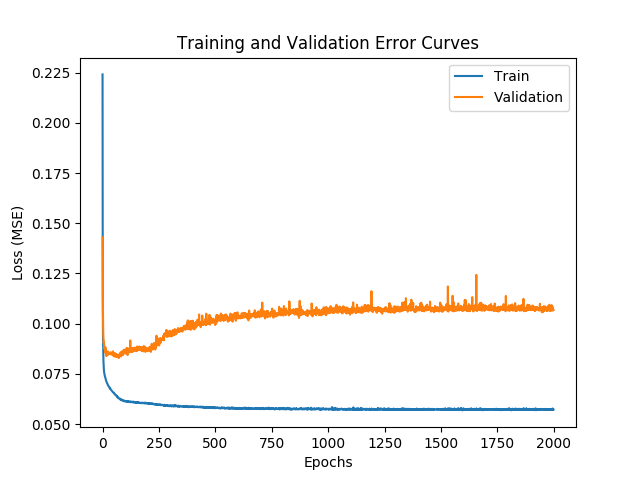

<IPython.core.display.Javascript object>


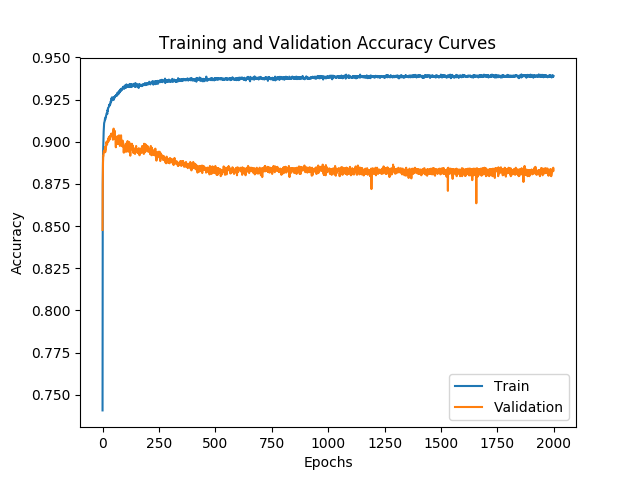

In [65]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 5 (2)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
